### 9.7 Chuỗi sang chuỗi
- Mô hình chuỗi sang chuỗi (Sequence to Sequence - seq2seq) dựa trên kiến trúc mã hóa - giải mã để sinh ra chuỗi đầu ra từ chuối đầu vào như minh họa. Cả bộ mã hóa và bộ giải mã sử dụng mạng nơ ron hồi tiếp RNN để xử lý các chuỗi đầu vào với độ dài khác nhau. Trạng thái ẩn của bộ giải mã được khởi tạo trực tiếp từ trạng thái ẩn của bộ mã hóa, giúp truyền thôn tin từ bộ mã hóa đến bộ giải mã.

    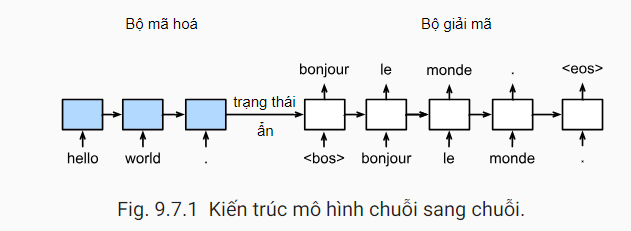

- Các tầng trong bộ mã hóa và bộ giải mã được minh họa như sau:

    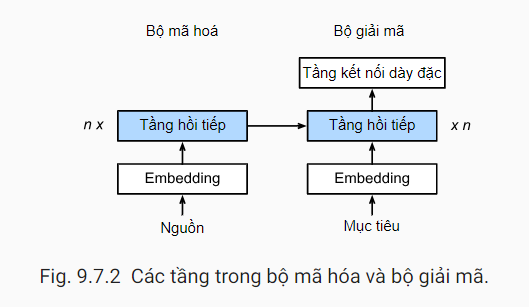

In [159]:
import collections
import math
import torch
from d2l import torch as d2l
from torch import nn
from torch.nn import functional as F

#### 9.7.1 Bộ Mã hóa
- Nhắc lại rằng bộ mã hóa của mô hình seq2seq mã hóa thông tin của các chuỗi đầu vào với độ dài khác nhau thành một vector ngữ cảnh c. Ta thường sử dụng các tầng RNN trong bộ mã hóa. Giả sử có một chuỗi đầu vào  trong đó  là từ thứ t. Tại bước thời gian t, mô hình RNN sẽ có hai vecto đầu vào: vector đặc trưng  và trạng thái ẩn của bước thời gian trước đó h_(t - 1). Ta ký hiệu phép chuyển đổi của các trạng thái ẩn trong RNN  bằng hàm f:

    

- Tiếp theo, bộ mã hóa nắm bắt thông tin của tất cả các trạng thái ẩn và mã hóa chúng thành vector ngữ cảnh c bằng hàm q():

    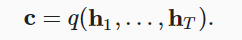

- Ví dụ, nếu chúng ta chọn q là 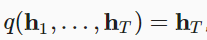, thì vector ngữ cảnh sẽ là trạng thái ẩn của bước thời gian cuối cùng h_T.

- Cho đến nay ta mới mô tả bộ mã hóa sử dụng mạng RNN một chiều, ở đó trạng thái ẩn của mỗi bước thời gian chỉ phụ thuộc vào các bước thời gian trước. Ta cũng có thể sử dụng các dạng RNN khác nhau như GRU, LSTM hay RNN hai chiều để mã hóa chuỗi đầu vào.

1. Ta sử dụng __một tầng embedding từ ngữ__ để lấy vector đặc trưng tương ứng với chỉ số từ trong ngôn ngữ nguồn. Những vector đặc trưng này sẽ được truyền vào một mạng LSTM đa tầng. 
2. Batch đầu vào của bộ mã hóa là tensor hai chiều có bộ kích thước là (kích thước batch, độ dài chuỗi) với số lượng chuỗi bằng kích thước batch.
3. Bộ mã hóa trả về cả đàu ra của LSTM, gồm các trạng thái ẩn của tất cả các bước thời gian, cùng với trạng thái ẩn và ô nhớ ở bước thời gian cuối cùng.

In [160]:
from torch import Tensor


def init_seq2seq(module):
    """Initialize weights for sequence-to-sequence learning"""
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embedded_size, num_hiddens, num_layers, 
                 drop_out = 0):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedded_size)
        self.rnn = nn.LSTM(embedded_size, num_hiddens, num_layers, dropout= drop_out)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embeddings(X.t().type(torch.int64))

        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)

        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state



In [161]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))
d2l.check_shape(enc_state[0], (num_layers, batch_size, num_hiddens)) # Hidden states
d2l.check_shape(enc_state[1], (num_layers, batch_size, num_hiddens)) # Memory

#### 9.7.2 Bộ giải mã
- Như đã giới thiệu, vector ngữ cảnh c mã hóa thông tin của toàn bộ chuỗi đầu vào . Giả sử như đầu ra của tập huấn luyện là . Tại mỗi bước thời gian t', xác suất có điều kiện của đầu ra  sẽ phụ thuộc vào đầu ra trước đó  và vector ngữ cảnh c, tức là:

    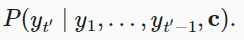

- Do đó, chúng ta có thể sử dụng một mạng RNN khác trong bộ giải mã. Tại mỗi bước thời gian t', bộ giải mã cập nhật trạng thái ẩn của nó thông qua ba đầu vào: vector đặc trưng  của , vector ngữ cảnh __c__ và trạng thái ẩn tại bước trước đó . Hàm g() dưới đây biểu diễn quá trình biến đổi trạng thái ẩn của mạng RNN trong bộ giải mã.

    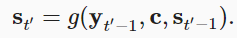

- Khi lập trình, ta sử dụng trực tiếp __trạng thái ẩn của bộ mã hóa ở bước thời gian cuối cùng__ để khởi tạo trạng thái ẩn của bộ giải mã. Điều này đỏi hỏi bộ mã hóa và bộ giải mã phải có cùng số tầng và số nút ẩn. 
- Các bước tính toán lượt truyền xuôi trong bộ giải mã gần giống trong bộ mã hóa. Điểm khác biệt duy nhất là có thêm môt tầng kết nối dày đặc với kích thước bằng kích thước bộ từ vựng được đặt ở sau các tầng LSTM. 

In [162]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence-to-sequence learning"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs[1] # Sử dụng hidden_state cuối cùng và ô nhớ cuối cùng làm 
                                  # state của lstm tại decoder
    
    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        # H shape ((num_layers, batch_size, num_hiddens))
        out, state = self.rnn(embs, state)
        # Output shape: (batch_size, num_steps, num_hiddens)
        out = self.dense(out).swapaxes(0, 1)
        return out, state
        

In [163]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
# Output shape: (batch_size, num_steps, vocab_size)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 9, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

#### 9.7.3 Hàm loss
- Tại mỗi bước thời gian, bộ giải mã tạo ra một vector điểm tin cậy có kích thước bằng bộ từ vựng để dự đoán các từ. Tương tự như trong mô hình hóa ngôn ngữ, ta có thể áp dụng softmax để tính xác suất và sau đó sử dụng hàm mất mát entropy chép để tính los. 
- __Lưu ý rằng ta đã đệm các câu đích để chúng có cùng độ dài nhưng không cần tính los trên các ký tự đệm này__.

In [ ]:
class EncoderDecoder(d2l.Classifier):
    """The base class for the encoder--decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

In [165]:
class Seq2Seq(d2l.EncoderDecoder):
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train = False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.lr)
    

In [166]:
def loss(self, Y_hat, Y):
    l = d2l.Classifier.loss(Y_hat, Y, averaged = False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l*mask).sum() / mask.sum()

#### 10.7.6 Training

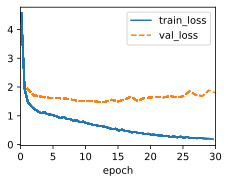

In [167]:
data = d2l.MTFraEng(batch_size = 128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

model = Seq2Seq(encoder, decoder, tgt_pad = data.tgt_vocab["<pad>"], lr = 0.005)
trainer = d2l.Trainer(30, 1, 1)
trainer.fit(model, data)

In [168]:
src, tgt, src_valid_len, _ = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [169]:
print(src)

tensor([[71,  2,  3,  4,  4,  4,  4,  4,  4]])


In [170]:
print(tgt)

tensor([[  3, 176,   2,   4,   5,   5,   5,   5,   5]])


In [171]:
print(src_valid_len)

tensor([3])


In [172]:
tgt[:, (0)].unsqueeze(1)

tensor([[3]])

In [ ]:
# @d2l.add_to_class(d2l.EncoderDecoder)  #@save
# def predict_step(self, batch, device, num_steps,
#                  save_attention_weights=False):
#     batch = [a.to(device) for a in batch]
#     src, tgt, src_valid_len, _ = batch
#     enc_all_outputs = self.encoder(src)
#     dec_state = self.decoder.init_state(enc_all_outputs)
#     outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
#     for _ in range(num_steps):
#         Y, dec_state = self.decoder(outputs[-1], dec_state)
#         outputs.append(Y.argmax(2))
#         # Save attention weights (to be covered later)
#         if save_attention_weights:
#             attention_weights.append(self.decoder.attention_weights)
#     return torch.cat(outputs[1:], 1), attention_weights

In [179]:
@d2l.add_to_class(d2l.EncoderDecoder)
def predict_step(self, batch, device, num_steps):
    batch = [a.to(device) for a in batch]
    src, tgt, _, _ = batch # Lấy source và target từ batch

    decoder_state = self.decoder.init_state(self.encoder(src)) # Cho source đi qua decoder để lấy dec_state

    Y = tgt[:, (0)].reshape(-1, 1) # lấy token đầu tiên của target (token mở đầu câu)
    outputs = Y
    for _ in range(num_steps):
        Y, decoder_state = self.decoder(Y, decoder_state)
        Y = Y.argmax(2)
        outputs = torch.concat((outputs, Y), dim = 1)

    return outputs[:, 1:].tolist()

In [180]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)

# print(data.tgt_vocab.to_tokens(preds[3]))
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):   
        if token == '<eos>':
            break
        translation.append(token + " ")
    print(f'{en} => {"".join(translation)}')

go . => va ! 
i lost . => j'ai perdu . 
he's calm . => il est mouillé . 
i'm home . => je suis <unk> ! 


In [ ]:
# engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# preds, _ = model.predict_step(
#     data.build(engs, fras), d2l.try_gpu(), data.num_steps)
# for en, fr, p in zip(engs, fras, preds):
#     translation = []
#     for token in data.tgt_vocab.to_tokens(p):
#         if token == '<eos>':
#             break
#         translation.append(token)
#     print(f'{en} => {translation}, bleu,'
#           f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', '<unk>', '!'], bleu,0.418
